In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
dataset = read_csv('Downloads/AgraLSTM.csv');

In [ ]:
dataset

,NSP Male/ NewMicConfMale,NSP Female/ NewMicConf Female,NSP Total/ NewMicConf Total,NEP Male,NEP Female,0-14 yrs NSP(NewAll207+) Male,0-14 yrs NSP(NewAll207+) Female,15-24 yrs NSP(NewAll207+) Male,15-24 yrs NSP(NewAll207+) Female,25-34 yrs NSP(NewAll207+) Male,...,35-44 yrs NSP(NewAll207+) Female,45-54 yrs NSP(NewAll207+) Male,45-54 yrs NSP(NewAll207+) Female,55-64 yrs NSP(NewAll207+) Male,55-64 yrs NSP(NewAll207+) Female,65 & above yrs NSP(NewAll207+) Male,65 & above yrs NSP(NewAll207+) Female,Total Failure,SumOfHIV_Tested,SumOfHIV_infected
0,335,156,491,121,154,9,15,62,49,67,...,26,56,17,45,9,21,5,13,0,0
1,522,273,795,185,206,11,20,133,85,110,...,44,76,22,61,14,25,12,23,0,0
2,444,205,649,176,187,12,18,110,80,84,...,30,72,12,41,11,24,6,16,0,0
3,453,233,686,115,176,13,19,112,64,73,...,41,78,23,38,19,33,3,25,0,0
4,476,243,719,166,212,12,26,97,68,86,...,50,76,25,64,16,26,7,22,0,0
5,490,227,717,196,252,12,23,115,79,94,...,34,75,11,63,27,27,4,15,0,0
6,424,217,641,174,198,14,23,107,68,76,...,36,70,18,56,9,20,2,27,0,0
7,415,234,649,125,174,21,31,92,73,81,...,34,65,13,54,17,27,6,10,0,0
8,496,277,773,143,210,11,29,115,101,97,...,35,77,23,48,12,32,6,9,0,0
9,490,244,734,202,256,18,27,119,75,90,...,35,85,23,58,20,28,9,13,0,0


In [ ]:
encoder = LabelEncoder()

In [ ]:
values = dataset.values

In [ ]:
values[:,4] = encoder.fit_transform(values[:,4])

In [ ]:
values = values.astype('float32')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
scaled = scaler.fit_transform(values)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(scaled, 1, 1)

In [ ]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [ ]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.239905   0.217822   0.233871   0.523529   0.270270   0.272727   
2   0.684085   0.797030   0.724194   0.900000   0.783784   0.363636   
3   0.498812   0.460396   0.488710   0.847059   0.621622   0.409091   
4   0.520190   0.599010   0.548387   0.488235   0.486486   0.454545   
5   0.574822   0.648515   0.601613   0.788235   0.864865   0.409091   

   var7(t-1)  var8(t-1)  var9(t-1)  var17(t-1)  ...  var13(t)  var14(t)  \
1   0.407407   0.151163   0.125000    0.090909  ...      0.66  0.636364   
2   0.592593   0.976744   0.625000    0.318182  ...      0.38  0.575758   
3   0.518519   0.709302   0.555556    0.181818  ...      0.60  0.666667   
4   0.555556   0.732558   0.333333    0.545455  ...      0.78  0.636364   
5   0.814815   0.558140   0.388889    0.409091  ...      0.46  0.621212   

   var15(t)  var16(t)  var17(t)  var18(t)  var19(t)  var20(t)  var21(t)  \
1  0.481481  0.644068  0.318182     0.300  0.71

In [ ]:
values = reframed.values

In [ ]:
n_train_hours = 9

In [ ]:
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [ ]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9, 1, 36) (9,) (34, 1, 36) (34,)


In [ ]:
model = Sequential()

In [ ]:
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))

In [ ]:
model.add(Dense(1))

In [ ]:
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=2, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/500
5/5 - 1s - loss: 0.0562 - val_loss: 0.2530
Epoch 2/500
5/5 - 0s - loss: 0.0236 - val_loss: 0.2383
Epoch 3/500
5/5 - 0s - loss: 0.0180 - val_loss: 0.2456
Epoch 4/500
5/5 - 0s - loss: 0.0134 - val_loss: 0.2405
Epoch 5/500
5/5 - 0s - loss: 0.0178 - val_loss: 0.2540
Epoch 6/500
5/5 - 0s - loss: 0.0071 - val_loss: 0.2439
Epoch 7/500
5/5 - 0s - loss: 0.0156 - val_loss: 0.2555
Epoch 8/500
5/5 - 0s - loss: 0.0063 - val_loss: 0.2495
Epoch 9/500
5/5 - 0s - loss: 0.0068 - val_loss: 0.2410
Epoch 10/500
5/5 - 0s - loss: 0.0102 - val_loss: 0.2566
Epoch 11/500
5/5 - 0s - loss: 0.0036 - val_loss: 0.2495
Epoch 12/500
5/5 - 0s - loss: 0.0035 - val_loss: 0.2477
Epoch 13/500
5/5 - 0s - loss: 0.0037 - val_loss: 0.2547
Epoch 14/500
5/5 - 0s - loss: 0.0063 - val_loss: 0.2467
Epoch 15/500
5/5 - 0s - loss: 0.0054 - val_loss: 0.2470
Epoch 16/500
5/5 - 0s - loss: 0.0072 - val_loss: 0.2598
Epoch 17/500
5/5 - 0s - loss: 0.0080 - val_loss: 0.2364
Epoch 18/500
5/5 - 0s - loss: 0.0152 - val_loss: 0.2640
E

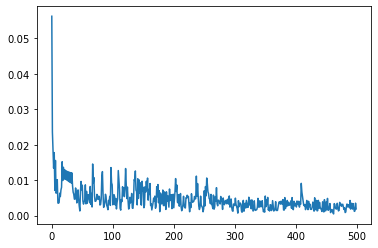

In [ ]:
pyplot.plot(history.history['loss'], label='train')

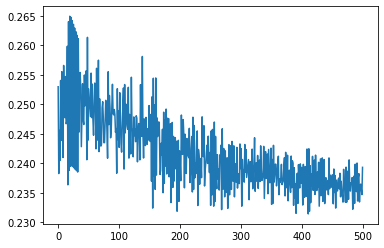

In [ ]:
pyplot.plot(history.history['val_loss'], label='test')

In [ ]:
yhat = model.predict(test_X)

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [ ]:
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)test_y = test_y.reshape((len(test_y), 1))

ValueError: operands could not be broadcast together with shapes (34,36) (22,) (34,36) 

In [ ]:
test_y = test_y.reshape((len(test_y), 1))

In [ ]:
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)

In [ ]:
inv_y = scaler.inverse_transform(inv_y)

ValueError: operands could not be broadcast together with shapes (34,36) (22,) (34,36) 

In [ ]:
inv_y = inv_y[:,0]

In [ ]:
yhat

array([[-0.0087252 ],
       [-0.01388808],
       [-0.00619544],
       [-0.02328995],
       [-0.01433478],
       [-0.02173206],
       [-0.02207628],
       [-0.02114848],
       [-0.00064607],
       [-0.0150957 ],
       [-0.01299329],
       [-0.01598111],
       [-0.0104646 ],
       [-0.02613569],
       [-0.01522864],
       [-0.01862259],
       [-0.01013798],
       [-0.0208336 ],
       [ 0.00436825],
       [-0.00742164],
       [-0.00540168],
       [ 0.01272094],
       [-0.00596264],
       [-0.00408791],
       [ 0.00401082],
       [ 0.00502841],
       [-0.02186539],
       [-0.01121168],
       [ 0.01326595],
       [ 0.00618017],
       [-0.00111369],
       [-0.01101898],
       [-0.01601112],
       [-0.01281879]], dtype=float32)

In [1]:
inv_y.shape()

NameError: ignored